# 5-Qubit Code: Syndrome Measurement

#### Syndrome desctiptions:

- $S_1$ = $ZXXZI$
- $S_2$ = $XXZIZ$
- $S_3$ = $XZIZX$
- $S_4$ = $ZIZXX$

##### Complete Syndrome Lookup Table

*Here's a reference table for all 15 possible single-qubit Pauli errors in the 5-qubit code:*

- **X Errors:**
$$
\begin{array}{lcr}
\textbf{Qubit} & \textbf{Syndrome}  \\
\hline
q_0 & 1001 \\
q_1 & 0100 \\
q_2 & 1010 \\
q_3 & 0101 \\
q_4 & 0010
\end{array}
$$

- **Z Errors:**
$$
\begin{array}{lcr}
\textbf{Qubit} & \textbf{Syndrome}  \\
\hline
q_0 & 0110 \\
q_1 & 0011 \\
q_2 & 0001 \\
q_3 & 1000 \\
q_4 & 1100
\end{array}
$$

- **Y Errors:**
$$
\begin{array}{lcr}
\textbf{Qubit} & \textbf{Syndrome}  \\
\hline
q_0 & 1111 \\
q_1 & 0111 \\
q_2 & 1011 \\
q_3 & 1101 \\
q_4 & 1110
\end{array}
$$

#### Expected Result for a $Z$ error on the first qubit:

The syndrome measurement should yield **0110**, which indicates:
- A **$Z$ error on qubit 0**
- Stabilizers $S_2$ and $S_3$ detect the error (bits $c_1$=1, $c_2$=1)
- Stabilizers $S_1$ and $S_4$ do not detect the error (bits $c_0$=0, $c_3$=0)

$$
\begin{array}{lcr}
\textbf{Stabilizer} & \textbf{Op on q0} & \textbf{Z error commutes?} & \textbf{Syndrome bit} \\
\hline
S_1 = ZXXZI & \textbf{Z} & yes (Z \times Z) & c_0 = 0 \\
S_2 = XXZIZ & \textbf{X} & no (Z \times X) & c_1 = 1 \\
S_3 = XZIZX & \textbf{X} & no (Z \times X) & c_2 = 1 \\ 
S_4 = ZIZXX & \textbf{Z} & yes (Z \times Z) & c_3 = 0 
\end{array}
$$

In [1]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.quantum_info import Statevector, Operator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def encode_5qubit():
    qc = QuantumCircuit(5, name='5-qubit code')

    qc.z(0)
    qc.h(0)
    qc.z(0)

    qc.cx(0,1)

    qc.h(0)
    qc.h(1)

    qc.cx(0,2)
    qc.cx(1,2)
    qc.cx(0,3)

    qc.h(0)
    qc.h(2)

    qc.cx(2,3)
    qc.cx(0,4)

    qc.h(0)
    qc.h(3)

    qc.cx(1,4)

    qc.h(1)

    qc.cx(2,4)

    return qc.to_gate(label='Encode 5-qubit')




def stabilizer(j):
    stabilizer_qc = QuantumCircuit(5)

    if j == 5:
        stabilizer_qc.z(0)
        stabilizer_qc.x(1)
        stabilizer_qc.x(2)
        stabilizer_qc.z(3)
    elif j == 6:
        stabilizer_qc.x(0)
        stabilizer_qc.x(1)
        stabilizer_qc.z(2)
        stabilizer_qc.z(4)
    elif j == 7:         
        stabilizer_qc.x(0)
        stabilizer_qc.z(1)
        stabilizer_qc.z(3)
        stabilizer_qc.x(4)
    elif j == 8:
        stabilizer_qc.z(0)
        stabilizer_qc.z(2)
        stabilizer_qc.x(3)
        stabilizer_qc.x(4)
      

    
    return stabilizer_qc.to_gate(label='Stabilizer').control(num_ctrl_qubits=1)

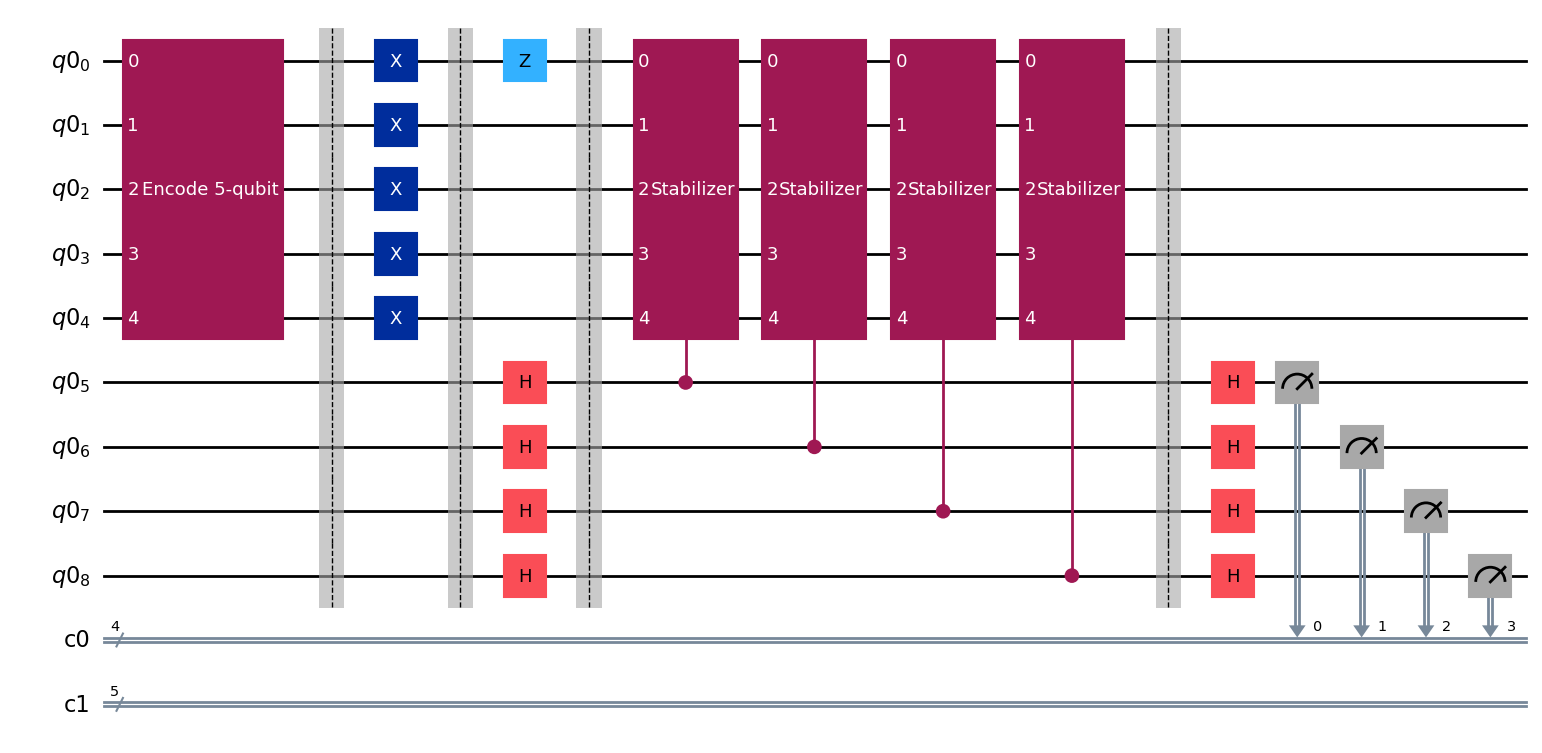

In [3]:
qr1 = QuantumRegister(9)
cr = ClassicalRegister(4)
cr1 = ClassicalRegister(5)
realqc = QuantumCircuit(qr1, cr, cr1)


#realqc.x(0) # to encode 1 state
realqc.append(encode_5qubit(), range(5))

realqc.barrier()


realqc.x(0)
realqc.x(1)
realqc.x(2)
realqc.x(3)
realqc.x(4)

realqc.barrier()


# introduce Z error on qubit 0
realqc.z(0) 

realqc.h(5)
realqc.h(6)
realqc.h(7)
realqc.h(8)

realqc.barrier()

for j in [5,6,7,8]:
    realqc.append(stabilizer(j), [j] + [0,1,2,3,4])
   

realqc.barrier()

realqc.h(5)
realqc.h(6)
realqc.h(7)
realqc.h(8)

realqc.measure([5,6,7,8],[0,1,2,3])

realqc.draw('mpl')

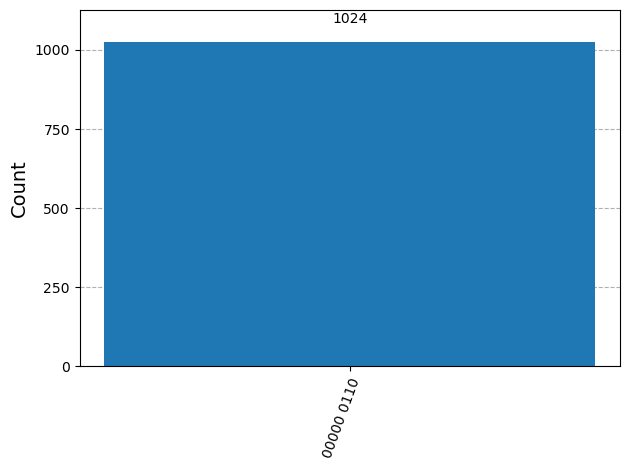

In [4]:
# transpile
sim = AerSimulator()
transpiled_realqc = transpile(realqc, sim)

result = sim.run(transpiled_realqc, shots = 1024).result()
counts = result.get_counts(0)

plot_histogram(counts)

In [5]:
with realqc.if_test((cr, 0b0110)):
    realqc.z(qr1[0])
with realqc.if_test((cr, 0b0011)):
    realqc.z(qr1[1])
with realqc.if_test((cr, 0b0001)):
    realqc.z(qr1[2])

realqc.barrier()
#realqc.draw('mpl')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=9, num_clbits=0, params=[]), qubits=(<Qubit register=(9, "q0"), index=0>, <Qubit register=(9, "q0"), index=1>, <Qubit register=(9, "q0"), index=2>, <Qubit register=(9, "q0"), index=3>, <Qubit register=(9, "q0"), index=4>, <Qubit register=(9, "q0"), index=5>, <Qubit register=(9, "q0"), index=6>, <Qubit register=(9, "q0"), index=7>, <Qubit register=(9, "q0"), index=8>), clbits=())

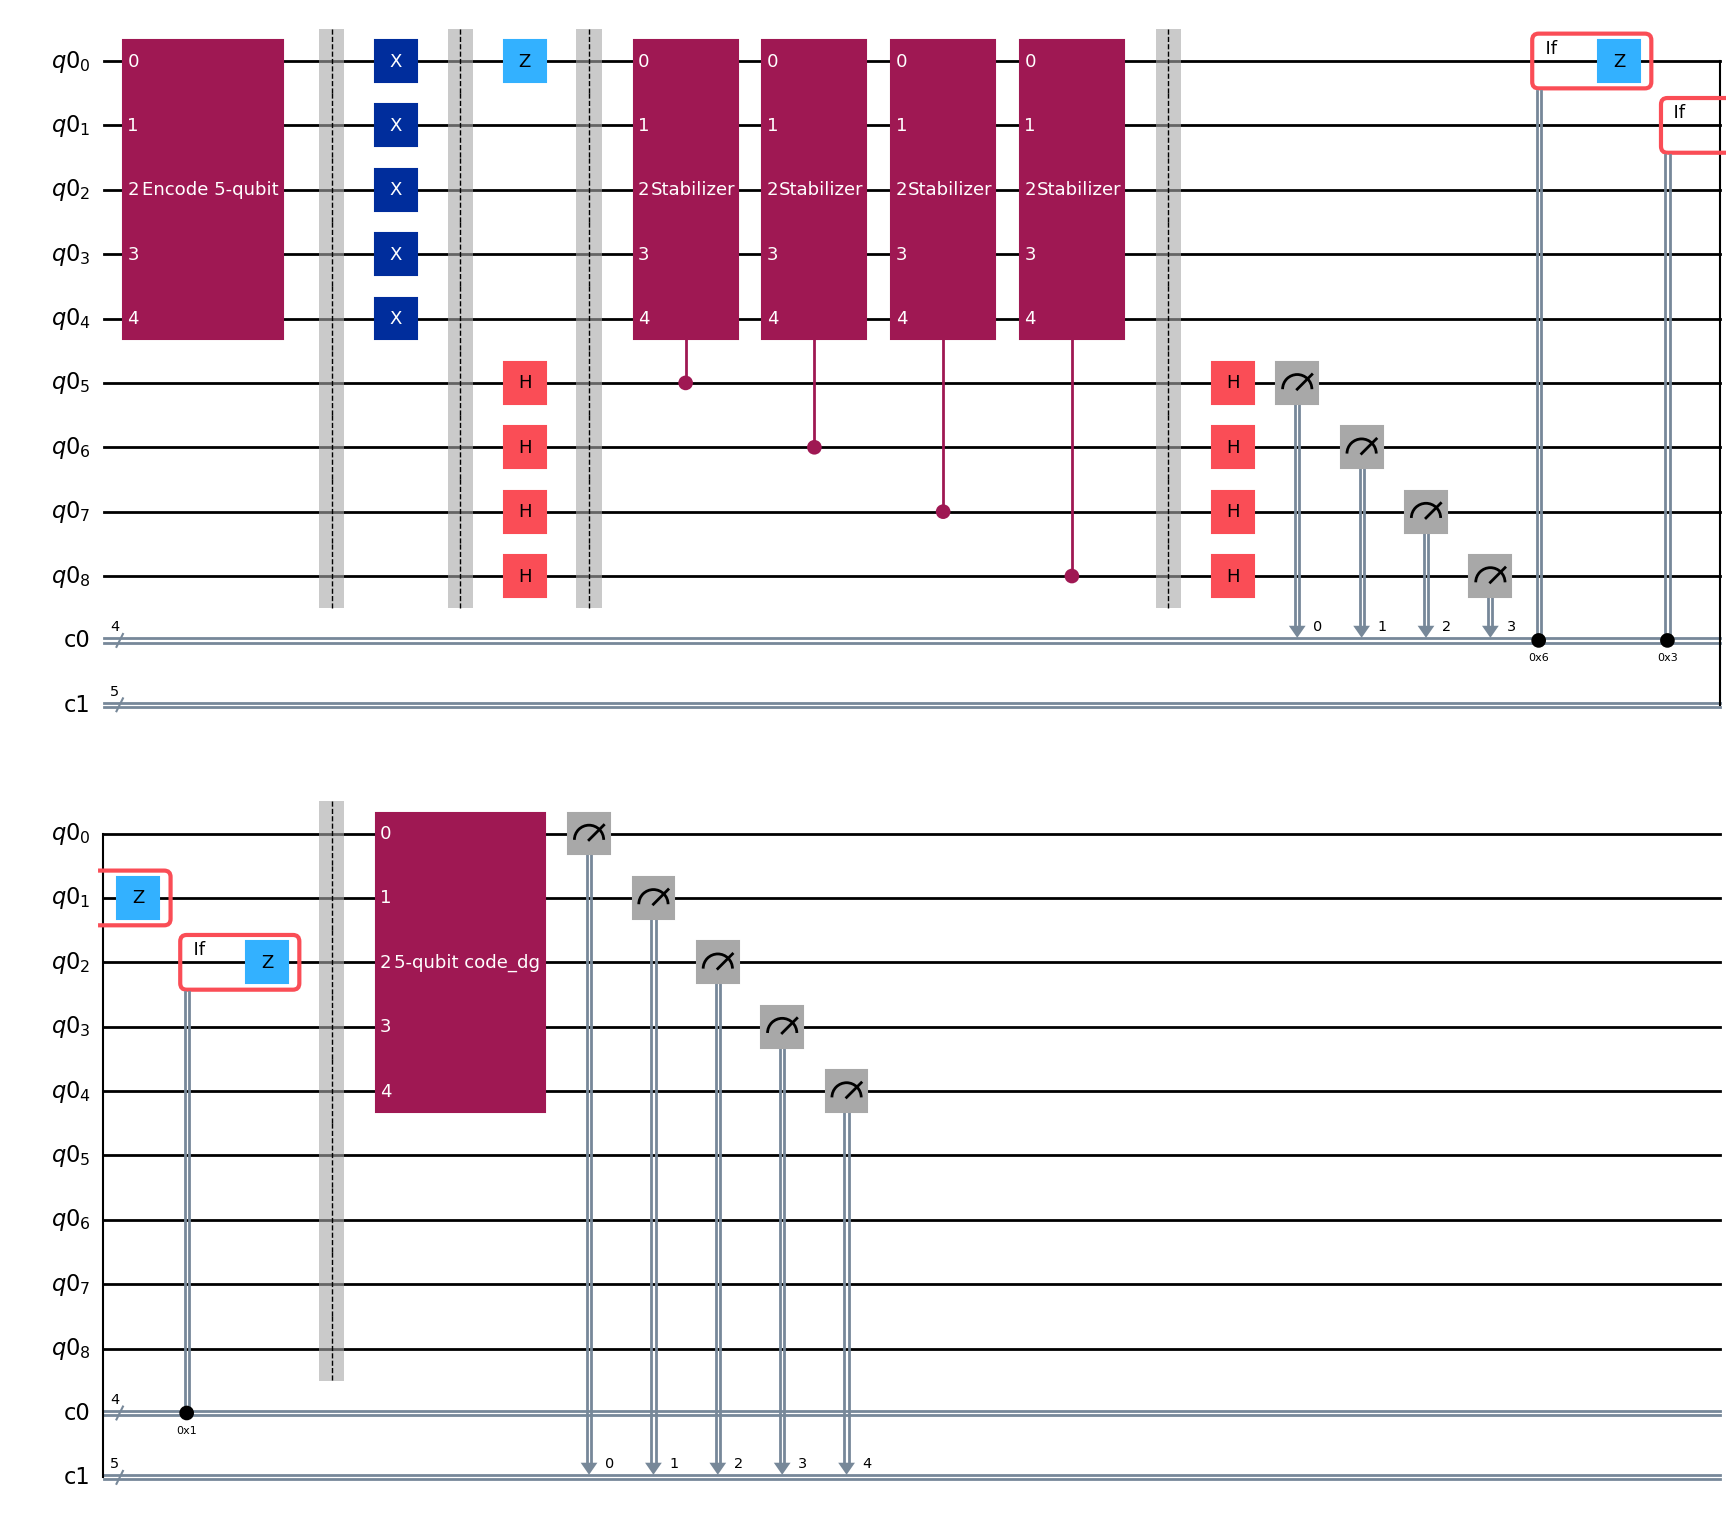

In [6]:
realqc.append(encode_5qubit().inverse(), range(5))
realqc.measure([qr1[0],qr1[1],qr1[2], qr1[3],qr1[4]],[cr1[0],cr1[1], cr1[2],cr1[3],cr1[4]])
realqc.draw('mpl')

{'00001 0110': 1024}


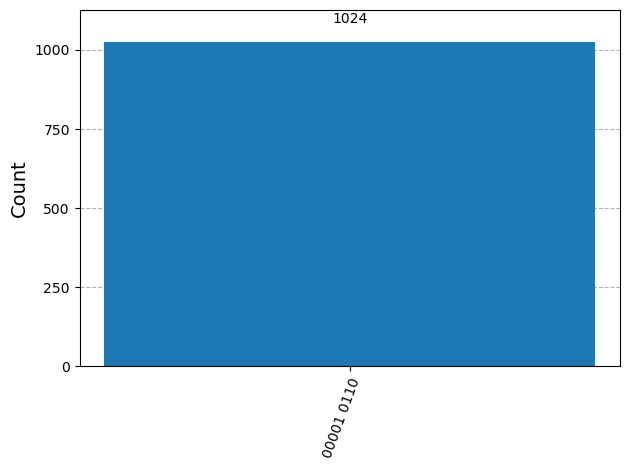

In [7]:
sim = AerSimulator()
transpiled= transpile(realqc, sim)
result = sim.run(transpiled, shots=1024).result()
print(result.get_counts())
plot_histogram(result.get_counts())